In [ ]:
!wget -O ./sample_data/iris.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv

--2020-06-26 03:48:19--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4549 (4.4K) [text/plain]
Saving to: ‘./sample_data/iris.csv’

./sample_data/iris. 100%[===================>]   4.44K  --.-KB/s    in 0s      

2020-06-26 03:48:19 (46.1 MB/s) - ‘./sample_data/iris.csv’ saved [4549/4549]



In [ ]:
from collections import defaultdict
import heapq
from copy import deepcopy
import numpy as np
from math import sqrt, ceil
from csv import reader
from random import seed, randrange
from typing import List, Dict, Set, Tuple

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

seed(10)

## Data Preprocessing:
- Defining dataset class
- Reading data
- Normalizing data (Optional if the dataset is already in the same scale)

In [ ]:
class Dataset (object):
  def __init__(self):
    self.dataset = None
    self.num_data = None
    self.num_features = None
    self.has_class = False
    self.class2num = None


  def load_csv(self, fileName: str, classification = False):
    self.dataset = list()
    self.has_class = classification

    with open(fileName, 'r') as file:
      csv_reader = reader(file)
      for row in csv_reader:
        if not row: # If it's not empty row
          continue
        self.dataset.append(row)

    self.num_data = len(self.dataset)

    if self.num_data > 0:
      row = self.dataset[0]
      self.num_features = len(row) - 1 if self.has_class else len(row)

    for i in range(self.num_features):
      self._str_col_to_float(i)

    if self.has_class:
      self._str_col_to_int(self.num_features)


  def _str_col_to_float(self, column: int):
    for row in self.dataset:
      row[column] = float(row[column].strip()) # In case there are some spaces


  def _str_col_to_int(self, column: int):
    classes = [row[column] for row in self.dataset]
    unique = set(classes)
    self.class2num = defaultdict(list)
    
    for i, c in enumerate(unique):
      self.class2num[c] = i

    for row in self.dataset:
      row[column] = self.class2num[row[column]]


  def _get_dataset_minmax(self):
    minmax_cols = []

    for i in range(self.num_features):
      cols = [row[i] for row in self.dataset]
      minmax_cols.append([min(cols), max(cols)])
    
    return minmax_cols

  def normalize_dataset(self, minmax_cols):
    minmax_cols = self._get_dataset_minmax()
    for row in self.dataset:
      for i in range(self.num_features):
        row[i] = (row[i] - minmax_cols[i][0]) / (minmax_cols[i][1] - minmax_cols[i][0])


  def split_dataset(self, ratio: float)-> Tuple:
    copy_dataset = deepcopy(self.dataset)
    num_train = ceil(len(copy_dataset) * ratio)
    np.random.shuffle(copy_dataset)
    return copy_dataset[:num_train], copy_dataset[num_train:]

In [ ]:
class Flower (object):
  def __init__ (self):
    self.num_features = 4
    self.sepal_length = None
    self.sepal_width = None
    self.petal_lenght = None
    self.petal_width = None
    self.species = None


In [ ]:
ds = Dataset()
ds.load_csv('./sample_data/iris.csv', classification=True)


In [ ]:
# Split data to train and test
train, test = ds.split_dataset(0.8)
print(f"Training data size: {len(train)}")
print(f"Testing data size: {len(test)}")

Training data size: 120
Testing data size: 30


## KNN

### Step 1: Calculate Euclidean Distance

In [ ]:
def euclidean_dist(f1 : List, f2 : List) -> float:
  dist = 0.0
  for i in range(len(f1) - 1):
    dist += (f1[i] - f2[i]) ** 2

  return sqrt(dist)

### Step 2: Get Nearest Neighbors

In [ ]:
def get_k_neighbors (k:int, train: List[List], target_data: List):
  pq = []
  for data in train:
    dist = euclidean_dist(data, target_data)
    c = data[-1]
    if (len(pq) == k):
      heapq.heappushpop(pq, (-dist, c))  # The heapq in python by default is min-heap, so we negate the distance
    else:
      heapq.heappush(pq, (-dist, c))

  return list(pq)

### Step 3: Make Predictions
We provide 2 options for predicting the class:
1. uniform
2. weighted

In [ ]:
def predict_class(k:int, train: List[List], target_data: List, uniform=True):
  neg_dist_class_tuples = get_k_neighbors(k, train, target_data)
  pred = None
  if uniform:
    classes = [c for neg_d, c in neg_dist_class_tuples]
    pred = max(set(classes), key=classes.count)
  else:
    class2weightedSum = defaultdict(float)
    for neg_d, c in neg_dist_class_tuples:
      class2weightedSum[c] += -1/neg_d if neg_d else 0
    pred = max(class2weightedSum.items(), key=lambda x: x[1])[0]

  return pred

### KNN wrapper

In [ ]:
def KNN(k:int, train: List[List], target_data:List[List], uniform=True):
  return [predict_class(k, train, target, uniform) for target in target_data]

## Run and evaluate KNN

In [ ]:
# Calculate accuracy percentage
def accuracy_metric(groundtruth, predicted):
	correct = 0
	for i in range(len(groundtruth)):
		if groundtruth[i] == predicted[i]:
			correct += 1
	return correct / float(len(groundtruth)) * 100.0

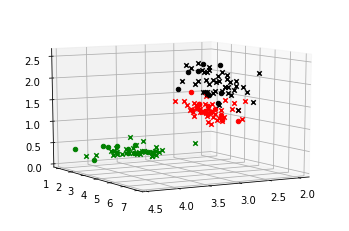

In [ ]:
# Use 2 dimension data for testing code
simple_train = [data[1:] for data in train]
simple_test  = [data[1:] for data in test]

plot_colors = ['green', 'black', 'red']
plot_train_symbols = 'x'
plot_test_symbols  = 'o'
plot_labels = ['0', '1', '2']
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
for data in simple_train:
  axes.scatter(data[0], data[1], data[2], c=plot_colors[data[-1]], marker=plot_train_symbols)

for data in simple_test:
  axes.scatter(data[0], data[1], data[2], c=plot_colors[data[-1]], marker=plot_test_symbols)

# rotate the axes and update
axes.view_init(10, 60)

In [ ]:
K = ceil(sqrt(len(train)))
if K % 2 == 0:
  K += 1
# K = 3
print(f"K = {K}") 

preds = KNN(K, train, test, False)
groundtruth = [data[-1] for data in test]
acc = accuracy_metric(groundtruth, preds)
print(f"Accuracy: {acc}")

K = 11
Accuracy: 96.66666666666667
